Welcome All, below I intend to demonstrate the simulated implementation of one of the most famous trading strategies on the open bitcoin dataset kindly shared here. I will flag up some of the many gotchas in this type of simulation. The strategy is attributed to Richard Dennis and his team of "turtle" traders, check out the book "Way of the Turtle" for more details.

Note I would strongly recommend that you not actually trade this, this is purely a simple example to highlight various tricks and pitfalls with the data. This kernel does not consitute trading or financial advice in anyway. Bitcoin is a particularly volatile market with some unique challenges and not the place to start in my limited opinion if you are interested in algorithmic trading.

This is a work in progress, please comment if you'd like to see more and I will extend it for the execution simulation

In [1]:

import numpy as np 
import pandas as pd 
import datetime
import os

#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

print('Data listing...')
print(os.listdir('../input/bitcoin-historical-data'))

# read in the data and apply our conversion function, this spits out a DataFrame with the DateTimeIndex already in place
print('Using bitstampUSD_1-min_data...')
data = pd.read_csv('../input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2017-05-31.csv', parse_dates=True, date_parser=dateparse, index_col=[0])

print('Total null open prices: %s' % data['Open'].isnull().sum())

Data listing...
['bitstampUSD_1-min_data_2012-01-01_to_2017-05-31.csv', 'btceUSD_1-min_data_2012-01-01_to_2017-05-31.csv', 'btcnCNY_1-min_data_2012-01-01_to_2017-05-31.csv', 'coinbaseUSD_1-min_data_2014-12-01_to_2017-05-31.csv', 'coincheckJPY_1-min_data_2014-10-31_to_2017-05-31.csv', 'krakenEUR_1-min_data_2014-01-08_to_2017-05-31.csv', 'krakenUSD_1-min_data_2014-01-07_to_2017-05-31.csv']
Using bitstampUSD_1-min_data...
Total null open prices: 1190473


In [2]:
# First thing is to fix the data for bars/candles where there are no trades. 
# Volume/trades are a single event so fill na's with zeroes for relevant fields...
data['Volume_(BTC)'].fillna(value=0, inplace=True)
data['Volume_(Currency)'].fillna(value=0, inplace=True)
data['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

# check how we are looking now, should be nice and clean...
print(data)

                        Open     High      Low    Close  Volume_(BTC)  \
Timestamp                                                               
2011-12-31 07:52:00     4.39     4.39     4.39     4.39      0.455581   
2011-12-31 07:53:00     4.39     4.39     4.39     4.39      0.000000   
2011-12-31 07:54:00     4.39     4.39     4.39     4.39      0.000000   
2011-12-31 07:55:00     4.39     4.39     4.39     4.39      0.000000   
2011-12-31 07:56:00     4.39     4.39     4.39     4.39      0.000000   
2011-12-31 07:57:00     4.39     4.39     4.39     4.39      0.000000   
2011-12-31 07:58:00     4.39     4.39     4.39     4.39      0.000000   
2011-12-31 07:59:00     4.39     4.39     4.39     4.39      0.000000   
2011-12-31 08:00:00     4.39     4.39     4.39     4.39      0.000000   
2011-12-31 08:01:00     4.39     4.39     4.39     4.39      0.000000   
2011-12-31 08:02:00     4.39     4.39     4.39     4.39      0.000000   
2011-12-31 08:03:00     4.39     4.39     4.39     

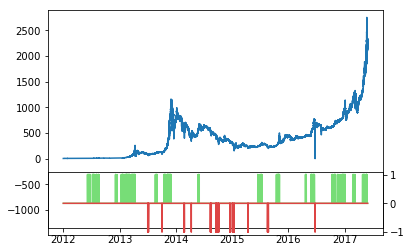

In [3]:
# The first thing we need are our trading signals. The Turtle strategy was based on daily data and
# they used to enter breakouts (new higher highs or new lower lows) in the 22-60 day range roughly.
# We are dealing with minute bars here so a 22 minute new high isn't much to get excited about. Lets
# pick an equivalent to 60 days then. They also only considered Close price so lets do the same...

signal_lookback = 60 * 24 * 60 # days * hours * minutes

# here's our signal columns
data['Buy'] = np.zeros(len(data))
data['Sell'] = np.zeros(len(data))

# this is our 'working out', you could collapse these into the .loc call later on and save memory 
# but I've left them in for debug purposes, makes it easier to see what is going on
data['RollingMax'] = data['Close'].shift(1).rolling(signal_lookback, min_periods=signal_lookback).max()
data['RollingMin'] = data['Close'].shift(1).rolling(signal_lookback, min_periods=signal_lookback).min()
data.loc[data['RollingMax'] < data['Close'], 'Buy'] = 1
data.loc[data['RollingMin'] > data['Close'], 'Sell'] = -1

# lets now take a look and see if its doing something sensible
import matplotlib
import matplotlib.pyplot as plt

fig,ax1 = plt.subplots(1,1)
ax1.plot(data['Close'])
y = ax1.get_ylim()
ax1.set_ylim(y[0] - (y[1]-y[0])*0.4, y[1])

ax2 = ax1.twinx()
ax2.set_position(matplotlib.transforms.Bbox([[0.125,0.1],[0.9,0.32]]))
ax2.plot(data['Buy'], color='#77dd77')
ax2.plot(data['Sell'], color='#dd4444')

